##### This model follows the same fine tuning process as model 09, but has the early stopping callback removed. The rate of validation loss and model performance based on rouge score does not seem to be directly negatively correlated, so the goal is to test if with a longer training time the model will continue to improve past the point of training cutoff by the early stopping callback.

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [4]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [5]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Tokenize data

In [6]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=2048, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=2048, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [7]:
tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [8]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [9]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [11]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [12]:
num_train_epochs = 25
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [13]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [14]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=25)

Epoch 1/25
212/212 [==============================] - 54s 208ms/step - loss: 5.7189 - val_loss: 5.0557
Epoch 2/25
212/212 [==============================] - 44s 207ms/step - loss: 4.9464 - val_loss: 4.8161
Epoch 3/25
212/212 [==============================] - 45s 214ms/step - loss: 4.6141 - val_loss: 4.6895
Epoch 4/25
212/212 [==============================] - 45s 214ms/step - loss: 4.3655 - val_loss: 4.6297
Epoch 5/25
212/212 [==============================] - 45s 214ms/step - loss: 4.1541 - val_loss: 4.6272
Epoch 6/25
212/212 [==============================] - 46s 214ms/step - loss: 3.9678 - val_loss: 4.5977
Epoch 7/25
212/212 [==============================] - 46s 215ms/step - loss: 3.7999 - val_loss: 4.6147
Epoch 8/25
212/212 [==============================] - 45s 210ms/step - loss: 3.6532 - val_loss: 4.6406
Epoch 9/25
212/212 [==============================] - 45s 215ms/step - loss: 3.5167 - val_loss: 4.6385
Epoch 10/25
212/212 [==============================] - 45s 213ms/step - l

# Visualize model

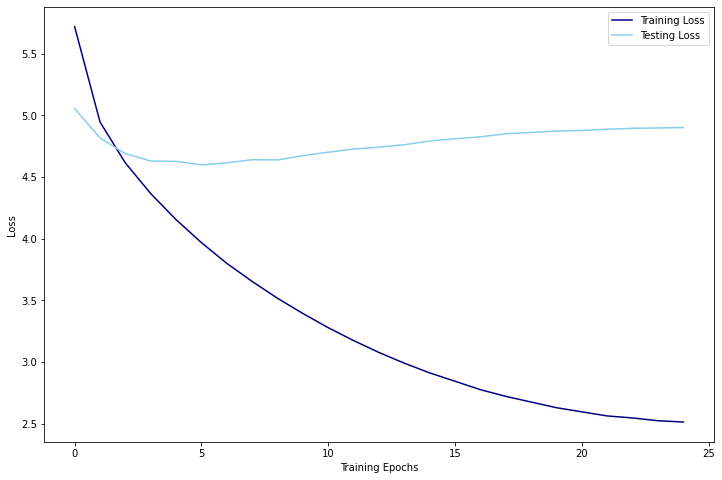

In [15]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is higher than the loss for the training data, indicating that the model is overfitting. The loss functions are also farther apart in this model than in model 9.

# Rouge scores for training data

In [16]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [32:18<00:00,  9.14s/it]


In [17]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 74.4186046511628
recall: 10.702341137123746
f-measure: 18.71345029239766
***************
rouge2
precision: 16.666666666666664
recall: 2.348993288590604
f-measure: 4.11764705882353
***************
rougeL
precision: 48.837209302325576
recall: 7.023411371237458
f-measure: 12.280701754385966
***************
rougeLsum
precision: 72.09302325581395
recall: 10.367892976588628
f-measure: 18.128654970760234
***************


# Rouge scores for test data

In [18]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [19]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [08:58<00:00,  9.13s/it]


In [20]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 56.86274509803921
recall: 12.663755458515283
f-measure: 20.714285714285715
***************
rouge2
precision: 8.0
recall: 1.7543859649122806
f-measure: 2.8776978417266186
***************
rougeL
precision: 29.411764705882355
recall: 6.550218340611353
f-measure: 10.714285714285715
***************
rougeLsum
precision: 47.05882352941176
recall: 10.480349344978166
f-measure: 17.14285714285714
***************


# Example model-generated summaries

In [21]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [22]:
print(rand_indexes)

[11, 56, 49]


In [24]:
#Reference summary example 1
print(test_labels[11])

Healed by Virgil's forgiveness, Dante moves on with him, moving up the bank out of the Tenth Bolgia and on into the darkness.
Dante can see little, but he hears the blast of a horn and, looking toward its source, thinks he sees towers.
Virgil warns him that these shapes are not towers but giants, each standing around the edge of the deepest pit of Hell, but so huge that they tower up out of the pit.
As Dante sees them more clearly, he is filled with fear, but in fact they are no threat to him.
The first is Nimrod, who (according to the  of Genesis) built the Tower of Babel in a proud and defiant attempt to reach Heaven and so caused the one language human beings had spoken up to that time to be lost.
He can only babble meaninglessly.
Next comes one of the giants who tried to unseat Jove, and he is bound.
Finally they come to Antaeus, an old antagonist of Hercules, who can speak and is not bound, and he is easily flattered into setting them down at the bottom of the pit.
Virgil holds Da

In [25]:
#Model summary example 1
print(test_preds[11])

In this chapter, Virgil tells the story of the year, and Virgil speaks of his story about his past, telling him that he would have to go ahead with his son, who has been living with his father and son, whose son will have to wait until they begin talking to


In [27]:
#Reference summary example 2
print(test_labels[56])

The king, leaning on Wolsey's shoulder, thanks him for foiling Buckingham's treasonous plot.
He asks for Buckingham's Surveyor, who had testified against his master, to be brought before him so that he can hear his evidence.
Queen Katherine enters, with the Dukes of Norfolk and Suffolk, and kneels before the king.
The king greets her and bids her rise, but she insists on remaining on her knees, since she is going to make a request of him.
She explains that she has been asked to intercede with the king by his subjects, who are upset at the levying of new taxes.
The people especially blame Wolsey, who originated the taxes, but their anger is also directed at the king, who is ultimately responsible.
She fears that rebellion will break out.
Norfolk backs up her argument, saying that employers have had to lay off their employees in order to pay the taxes, creating a desperate class of unemployed and starving people.
The king says he is unaware of the new tax.
Katherine explains that each su

In [28]:
#Model summary example 2
print(test_preds[56])

The king tells the king that he has been imprisoned in France, and Katherine.
The king says, as well as his heir to the king.
He tells him that he will not be able to give up his pardon.
He says that Katherine has already been given the go-ahead and


In [29]:
#Reference summary example 3
print(test_labels[49])

When Dante and Virgil come to the foot of the tower, they see two lights shining from it, and another light in the distance flashing in reply.
Dante wants to know what's going on, and Virgil points out something coming toward them across the marsh.
It's a little boat, and the demon who steers it, Phlegyas, gloats, thinking Dante is an evil soul that has come into his power, then swells with held-in rage when Virgil tells him they are only going to cross.
Virgil gets in the boat first, but it is only when Dante gets in that the boat sinks lower in the water.
As they cross, one of the spirits wallowing in the mire asks Dante who he is.
Dante recognizes him and feels no pity: Filippo Argenti is where he belongs.
Filippo reaches out toward the boat, but Virgil pushes him away, and blesses Dante for his indignation, saying that this man was utterly arrogant while he lived and is now furious because no good is remembered of him.
Many now living who think they are great kings will meet the sa

In [30]:
#Model summary example 3
print(test_preds[49])

Dante sees Dante and Virgil in the lake, but Dante sees one of the most famous human beings in the forest, and he runs into a lake.
Virgil speaks to Virgil and his father, so he can leave the house, and then tells the young man to go to Hell.


# Evaluation of model

Based on rouge scores, this model performed better than the baseline and better than most of the previous fined tuned models. It does score slightly worse than model 09, which was the same except for an addition of an early stopping callback; this callback seems to have improved performance in this previous model. Readability of the example generated summaries is similar to model 09.